In [1]:
!pip install scikit-learn pandas matplotlib seaborn xgboost lightgbm -q


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
!pip install gdown -q

# ✅ Download Train and Test files using gdown
!gdown --id 1OQWfTaTaRatB8gT3sg723LRtYYKBm5tU -O train.csv
!gdown --id 1MznJKj9_X4TBgnkbMWfBSBv9jyCQ6krd -O test.csv


/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1OQWfTaTaRatB8gT3sg723LRtYYKBm5tU
To: /content/train.csv
100% 1.32M/1.32M [00:00<00:00, 132MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1MznJKj9_X4TBgnkbMWfBSBv9jyCQ6krd
To: /content/test.csv
100% 131k/131k [00:00<00:00, 102MB/s]


In [4]:
import pandas as pd

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")


Data Preproccesing


In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb

In [6]:
train_ids = train['patient_id']
test_ids = test['patient_id']

X = train.drop(['patient_id', 'heart_attack_risk'], axis=1)
y = train['heart_attack_risk']

X_test_final = test.drop(['patient_id'], axis=1)

In [18]:
def split_bp(df):
    # Ensure 'bp' exists
    if 'bp' not in df.columns:
        return df

    # Convert to string
    df['bp'] = df['bp'].astype(str)

    # Create numeric columns
    df['bp_sys'] = np.nan
    df['bp_dia'] = np.nan

    # Loop safely
    for idx, val in df['bp'].items():
        try:
            if '/' in val:
                sys, dia = val.split('/')
                df.at[idx, 'bp_sys'] = float(sys)
                df.at[idx, 'bp_dia'] = float(dia)
            else:
                df.at[idx, 'bp_sys'] = float(val)
                df.at[idx, 'bp_dia'] = np.nan
        except:
            df.at[idx, 'bp_sys'] = np.nan
            df.at[idx, 'bp_dia'] = np.nan

    # Drop original 'bp'
    df.drop('bp', axis=1, inplace=True)

    return df





In [21]:
# Keep original DataFrame
X = train.drop(['patient_id', 'heart_attack_risk'], axis=1)
X_test_final = test.drop(['patient_id'], axis=1)

# Split bp column now, **before any scaling or label encoding**
X = split_bp(X)
X_test_final = split_bp(X_test_final)

print(X[['bp_sys', 'bp_dia']].head())


   bp_sys  bp_dia
0   158.0    88.0
1   165.0    93.0
2   174.0    99.0
3   163.0   100.0
4    91.0    88.0


In [23]:
# ✅ STEP 5: Encode categorical columns
cat_cols = ['sex', 'diet', 'country', 'continent', 'hemisphere']

for col in cat_cols:
    le = LabelEncoder()
    le.fit(list(X[col].astype(str)) + list(X_test_final[col].astype(str)))  # fit on both train+test
    X[col] = le.transform(X[col].astype(str))
    X_test_final[col] = le.transform(X_test_final[col].astype(str))


In [24]:
# ✅ STEP 6: Handle missing values
for col in X.columns:
    if X[col].dtype in ['int64', 'float64']:
        X[col] = X[col].fillna(X[col].median())
        X_test_final[col] = X_test_final[col].fillna(X[col].median())
    else:
        X[col] = X[col].fillna(X[col].mode()[0])
        X_test_final[col] = X_test_final[col].fillna(X[col].mode()[0])


In [25]:
# ✅ STEP 7: Scale numeric features
num_cols = X.select_dtypes(include=['int64','float64']).columns
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])
X_test_final[num_cols] = scaler.transform(X_test_final[num_cols])


In [26]:
# ✅ STEP 8: Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [34]:
# ✅ STEP 9: Train models
models = {
    "LogisticRegression": LogisticRegression(max_iter=500),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": lgb.LGBMClassifier()
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    # Use probabilities for ROC-AUC
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_val)[:, 1]  # probability of class 1
    else:
        # Some models like SVM may not have predict_proba
        y_prob = model.decision_function(X_val)

    acc = accuracy_score(y_val, preds)
    prec = precision_score(y_val, preds, zero_division=0)
    rec = recall_score(y_val, preds, zero_division=0)
    f1 = f1_score(y_val, preds, zero_division=0)
    roc = roc_auc_score(y_val, y_prob)  # ✅ Correct ROC-AUC calculation

    results[name] = [acc, prec, rec, f1, roc]

    print(f"\n🔹 {name} Results")
    print(classification_report(y_val, preds, zero_division=0))
    print("Confusion Matrix:\n", confusion_matrix(y_val, preds))
    print(f"ROC-AUC Score: {roc:.4f}")


🔹 LogisticRegression Results
              precision    recall  f1-score   support

           0       0.66      1.00      0.79      1045
           1       0.00      0.00      0.00       548

    accuracy                           0.66      1593
   macro avg       0.33      0.50      0.40      1593
weighted avg       0.43      0.66      0.52      1593

Confusion Matrix:
 [[1045    0]
 [ 548    0]]
ROC-AUC Score: 0.4947

🔹 RandomForest Results
              precision    recall  f1-score   support

           0       0.66      0.99      0.79      1045
           1       0.33      0.01      0.02       548

    accuracy                           0.65      1593
   macro avg       0.49      0.50      0.40      1593
weighted avg       0.54      0.65      0.52      1593

Confusion Matrix:
 [[1035   10]
 [ 543    5]]
ROC-AUC Score: 0.4941


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:40:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🔹 XGBoost Results
              precision    recall  f1-score   support

           0       0.65      0.80      0.72      1045
           1       0.34      0.19      0.24       548

    accuracy                           0.59      1593
   macro avg       0.50      0.50      0.48      1593
weighted avg       0.54      0.59      0.56      1593

Confusion Matrix:
 [[838 207]
 [443 105]]
ROC-AUC Score: 0.5104
[LightGBM] [Info] Number of positive: 2191, number of negative: 4179
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1898
[LightGBM] [Info] Number of data points in the train set: 6370, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.343956 -> initscore=-0.645714
[LightGBM] [Info] Start training from score -0.645714

🔹 LightGBM Results
              p

In [35]:
# ✅ STEP 10: Choose best model by Recall
best_model_name = results_df['Recall'].idxmax()
print("\n✅ Best Model (by Recall):", best_model_name)
best_model = models[best_model_name]

# Retrain on full training set
best_model.fit(X, y)


✅ Best Model (by Recall): XGBoost


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:41:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [36]:
# ✅ STEP 11: Predict on Test Dataset
test_preds = best_model.predict(X_test_final)


In [37]:
# ✅ STEP 12: Save Output CSV
output = pd.DataFrame({
    "patient_id": test_ids,
    "heart_attack_risk": test_preds
})
output.to_csv("EM20_QudraLisa_Task1_HeartAttack.csv", index=False)
print("\n✅ Predictions Saved: TeamCode_TeamName_Task1_Predictions.csv")



✅ Predictions Saved: TeamCode_TeamName_Task1_Predictions.csv


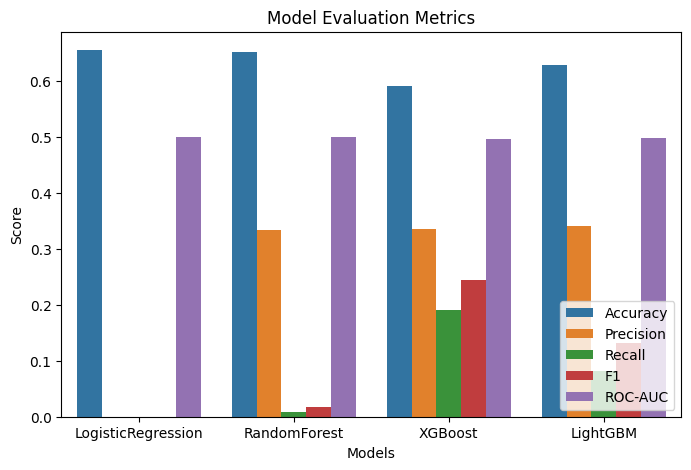

In [38]:
# ✅ STEP 13: Plot metrics for screenshot
plt.figure(figsize=(8,5))
sns.barplot(data=results_df.reset_index().melt(id_vars="index"), x="index", y="value", hue="variable")
plt.title("Model Evaluation Metrics")
plt.ylabel("Score")
plt.xlabel("Models")
plt.legend(loc="lower right")
plt.show()